# Sentiment Analysis

In this notebook we combine sentiment analysis and semantic search for tweets associated with bitcoin. 

- We will see that the sentiment of these tweets is correlated with the returns of bitcoin.
- We will visualise the patterns in sentiment throughout the semantic search space.
- We will use kdbai to perform semantic search to predict the sentiment of new unlabeled tweets.

In [1]:
## Uncomment this `pip install` command if you see import errors
# %pip install --quiet matplotlib umap-learn scikit-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import pykx as kx
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
kx.q('\l init.q')

pykx.Identity(pykx.q('::'))

### Load the data

- training set of approximately 12,000 tweets, each with embedding vectors, sentiment, sentiment score, and returns
- test set of approximatly 5,000 tweets, each with with embedding vectors and sentiment

***These embeddings and sentiment scores have been generated using publically available transformer models.***

In [3]:
train = kx.q('get `:/opt/kx/data/trainSentiment')
test  = kx.q('get `:/opt/kx/data/testSentiment')

### Market Impact

Here we group together the most positive/negative tweets and look at the bitcoin returns over 1 minute, 5 miuntes, 15 minutes, 30 minutes and 1 hour periods around the times of these tweets.  

Further analysis show that the impact of these tweets aprears to be a statistically significant predictor of price movements over this period.

***All results are quoted in basis points.***

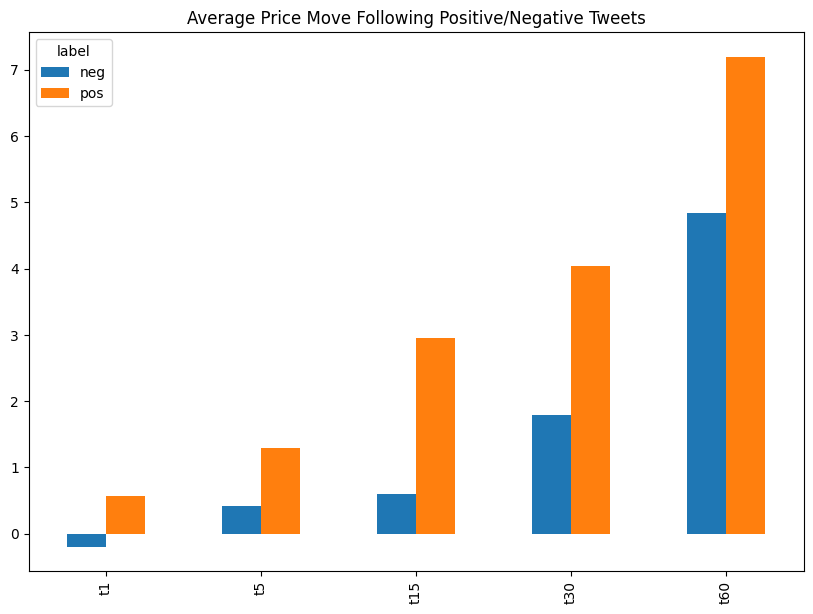

In [4]:
c = {'t1':'1e4*avg t1','t5':'1e4*avg t5','t15':'1e4*avg t15','t30':'1e4*avg t30','t60':'1e4*avg t60'}
b = {'label':"{$[x>0.9;`pos;x<0.6;`neg;`neu]}'[score]"}
stats = kx.q.qsql.select(train,columns=c,by=b).pd().loc[['neg','pos']]
stats.T.plot(kind='bar',title='Average Price Move Following Positive/Negative Tweets',figsize=(10,7))
plt.show()

### Vector Embeddings and Sentiment

Here we consider how the sentiment of our tweets varies over the geometry of the space of embedded vectors. As these embeddings depend upon the semantic structure of the tweets we could expect nearby vectors to have similar sentiment. In this two dimensional visulazation we colored the embedded vectors with their sentiment. 

***Clearly we can see that clusters of semantically similar tweets exist with the same sentiment.***

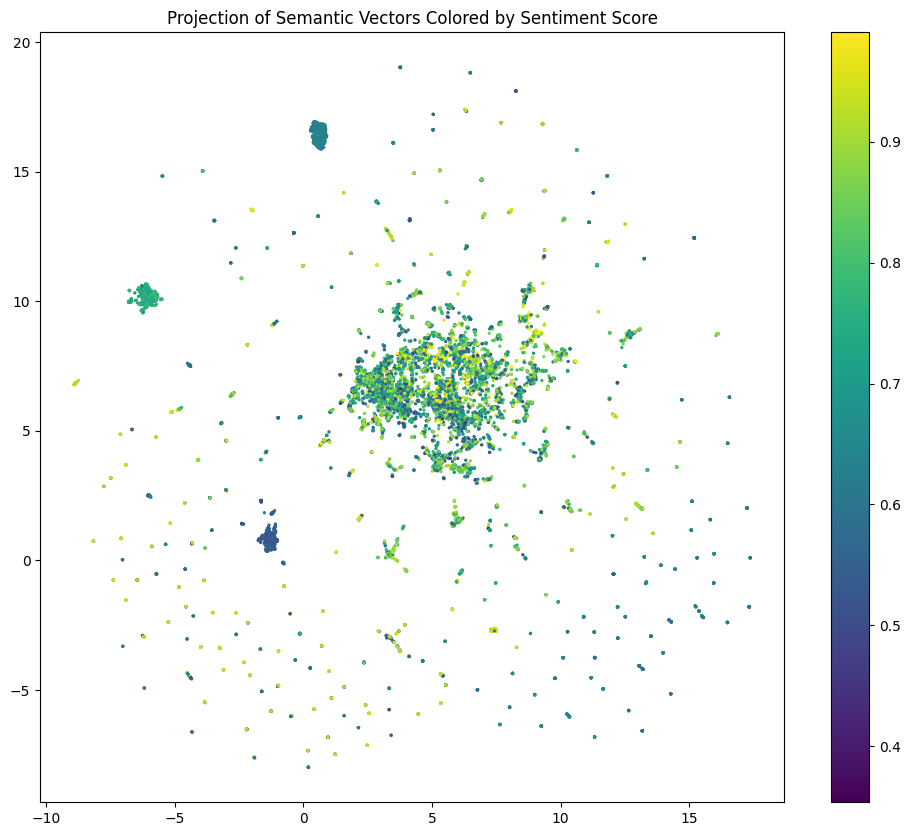

In [5]:
umap = UMAP(n_components=2, n_neighbors=5, min_dist=0.0)
umap.fit(train['vector'].py())
umapdf  = pd.DataFrame(umap.transform(train['vector'].py()),columns=['u0','u1'])
umapdf['sentiment'] = train['score'].py()
fig,ax=plt.subplots(1,figsize=(12,10))
im = ax.scatter(umapdf['u0'],umapdf['u1'],c=umapdf['sentiment'],s=2)
fig.colorbar(im, ax=ax)
ax.set_title("Projection of Semantic Vectors Colored by Sentiment Score")
plt.show()

### Build a Sentiment Classifier based on Semantic Search : Model 1

In the following example we use vector similarity search to classify the sentiment of a collection of unlabeled tweets. We then compare the sentiment results we have generated in this way to "true values" generated by a transformer model to verify that the labeling is working. 

***We use kdbai to build a inverted file index with product quantization. This allows for very fast searches with good accuracy.***

In [6]:
params = {'initData':train,'nclusters':5,'nsplits':32,'nbits':8}

kx.q.kdbai.init("ivfpq",
                "index_5_32",
                ["table_5_32",None],
                "vector",
                params)

kx.q.kdbai.append("index_5_32",train)

Setting the table: '.kdbai.table.table_5_32' as a global table within this process

Updating index with new vector data
Updating in-memory table: '.kdbai.table.table_5_32' with new data


pykx.Identity(pykx.q('::'))

In order to classify our unlabeled tweets we look for the 99 nearest neighbors and a majority vote of the sentiment based on the values of these similar tweets. 

***The resulting F1 score for this classifier based on the positive sentiment class is around 0.66. This indicates some predictive power in the model.***

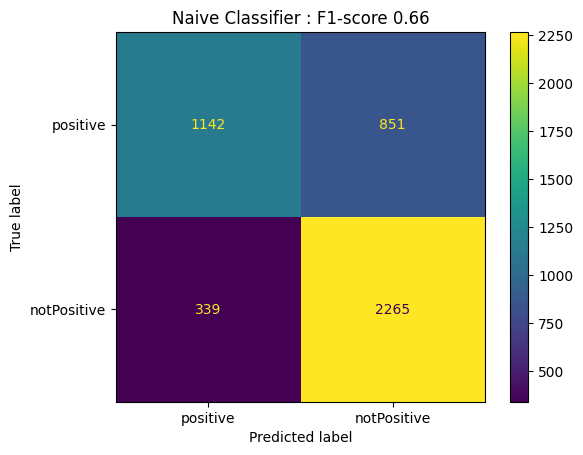

In [7]:
s = kx.q.kdbai.search("index_5_32",test['vector'],"sentiment",0,{'neighbors':99,'clusters':1})
test = kx.q.qsql.update(test,columns={"posPred":kx.q('{{sum[in[x`sentiment;`negative`neutral]] < 50} each x}',s)})
results = kx.q.qsql.select(test,columns={'true_sentiment':"{$[x in `negative`neutral;`notPositive;`positive]}'[sentiment]",
                                         'pred_sentiment':'?[posPred;`positive;`notPositive]'})
cm = confusion_matrix(results['true_sentiment'], results['pred_sentiment'], labels=["positive", "notPositive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["positive", "notPositive"])
disp.plot()
disp.ax_.set_title("Naive Classifier : F1-score {:.2f}".format((2*cm[0,0])/(2*cm[0,0]+cm[1,0]+cm[0,1])))
plt.show()

### Build a Sentiment Classifier based on Semantic Search : Model 2

To improve on the above model we apply two tricks. 

1. We subsample our training data to remove some imbalance in our input data.

In [8]:
b = kx.q('''{a:select from x where sentiment like "pos*";
             b:(neg `int$2*count a)?select from x where not sentiment like "pos*";
             a,b}''',train)

params = {'initData':b,'nclusters':5,'nsplits':32,'nbits':8}

kx.q.kdbai.init("ivfpq",
                "index_b_5_32",
                ["table_b_5_32",None],
                "vector",
                params)

kx.q.kdbai.append("index_b_5_32",b)

Setting the table: '.kdbai.table.table_b_5_32' as a global table within this process

Updating index with new vector data
Updating in-memory table: '.kdbai.table.table_b_5_32' with new data


pykx.Identity(pykx.q('::'))

2. We use the distances to the nearest neighbours to weight the sentiment values.

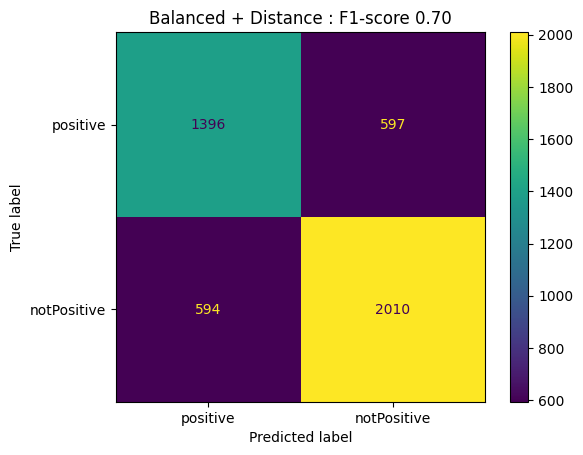

In [9]:
s = kx.q.kdbai.search("index_b_5_32",test['vector'],"sentiment",1,{'neighbors':99,'clusters':1})
test = kx.q.qsql.update(test,columns={"posPred":kx.q('{{.5 < wavg[0.00001+1%x`nn_dist] (`float$in[x`sentiment;enlist `positive])}each x}',s)})
results = kx.q.qsql.select(test,columns={'true_sentiment':"{$[x in `negative`neutral;`notPositive;`positive]}'[sentiment]",
                                         'pred_sentiment':'?[posPred;`positive;`notPositive]'})
cm = confusion_matrix(results['true_sentiment'], results['pred_sentiment'], labels=["positive", "notPositive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["positive", "notPositive"])
disp.plot()
disp.ax_.set_title("Balanced + Distance : F1-score {:.2f}".format((2*cm[0,0])/(2*cm[0,0]+cm[1,0]+cm[0,1])))
plt.show()

---